Dataset shape after cleaning: (9500, 2)
Class distribution:
category
Anxiety          1748
Bipolar          1555
ADHD             1508
Autism           1292
Depression       1262
BPD              1245
schizophrenia     890
Name: count, dtype: int64
Class weights: {np.int64(0): np.float64(0.8999621068586586), np.int64(1): np.float64(0.7763975155279503), np.int64(2): np.float64(1.050420168067227), np.int64(3): np.float64(1.0900745840504877), np.int64(4): np.float64(0.8727606798346348), np.int64(5): np.float64(1.0753905365632783), np.int64(6): np.float64(1.5248796147672552)}
Train: 6650, Val: 1425, Test: 1425
GloVe file not found. Using random embeddings.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Using device: cuda


Training Enhanced LSTM Model...
[LSTM] Epoch 1/15
  Train Loss: 2.0554
  Val Loss: 1.9263, Val Acc: 0.1775
  -> New best LSTM model saved (Val Acc: 0.1775)
[LSTM] Epoch 2/15
  Train Loss: 1.9820
  Val Loss: 1.9073, Val Acc: 0.2077
  -> New best LSTM model saved (Val Acc: 0.2077)
[LSTM] Epoch 3/15
  Train Loss: 1.8858
  Val Loss: 1.9630, Val Acc: 0.1607
[LSTM] Epoch 4/15
  Train Loss: 1.8531
  Val Loss: 1.8459, Val Acc: 0.2884
  -> New best LSTM model saved (Val Acc: 0.2884)
[LSTM] Epoch 5/15
  Train Loss: 1.4862
  Val Loss: 1.8519, Val Acc: 0.2870
[LSTM] Epoch 6/15
  Train Loss: 1.2475
  Val Loss: 1.9677, Val Acc: 0.3558
  -> New best LSTM model saved (Val Acc: 0.3558)
[LSTM] Epoch 7/15
  Train Loss: 1.1221
  Val Loss: 1.6698, Val Acc: 0.4295
  -> New best LSTM model saved (Val Acc: 0.4295)
[LSTM] Epoch 8/15
  Train Loss: 0.9320
  Val Loss: 1.5639, Val Acc: 0.4968
  -> New best LSTM model saved (Val Acc: 0.4968)
[LSTM] Epoch 9/15
  Train Loss: 0.7357
  Val Loss: 1.5489, Val Acc: 0.5046

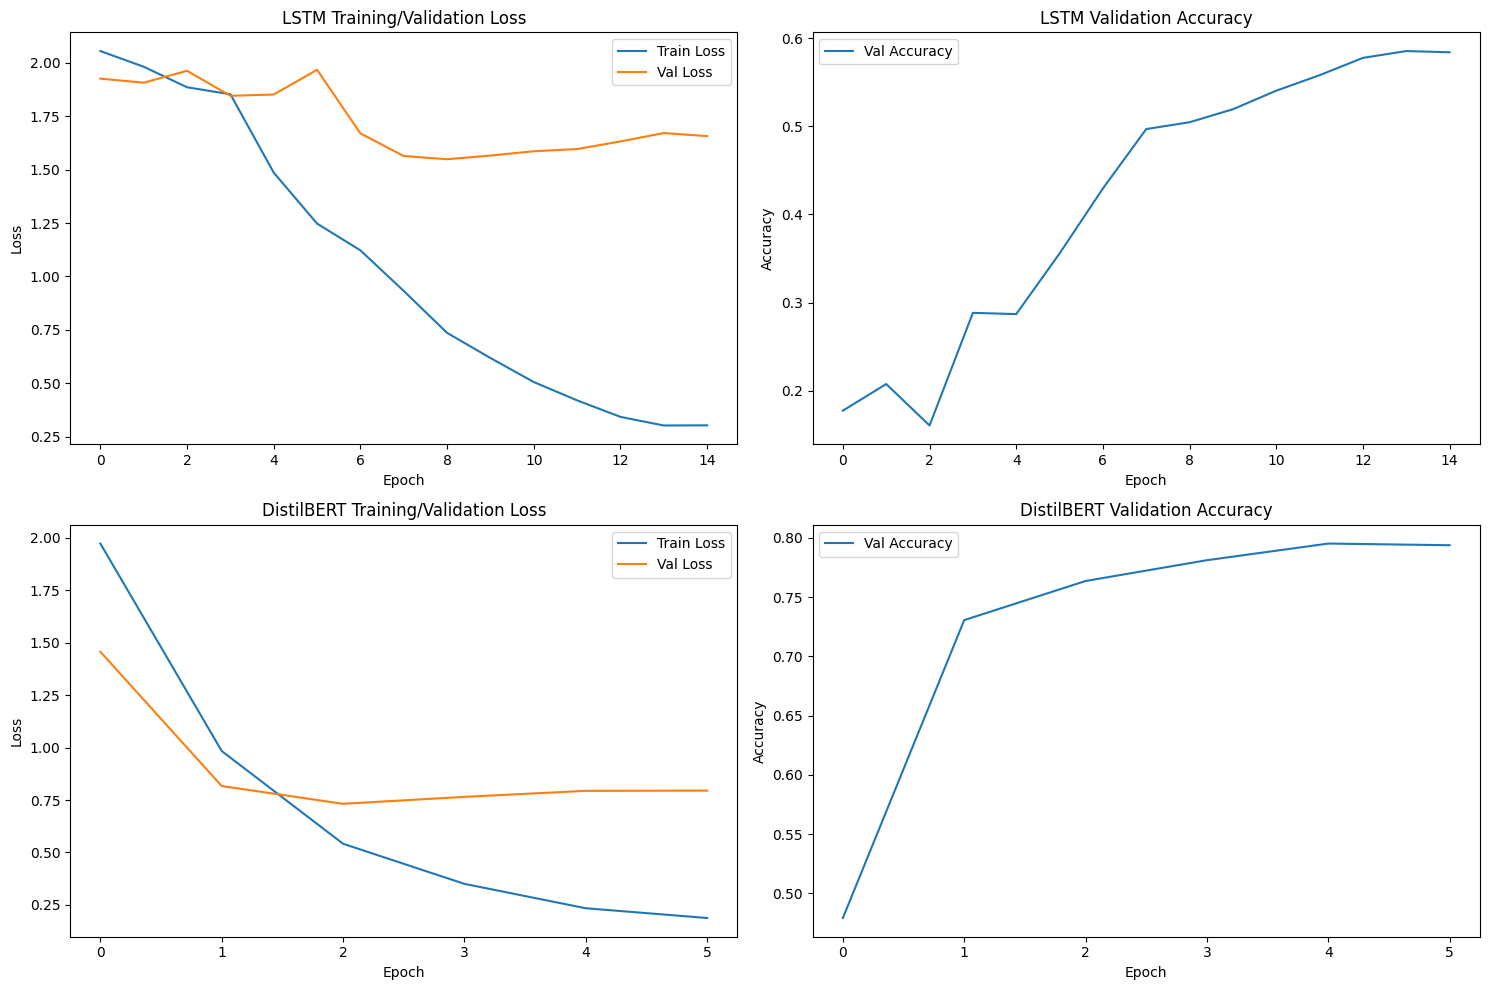


🎯 Target Achieved: ❌ (Target: >80%, Achieved: 14.32%)


In [ ]:
import random
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import DistilBertTokenizer, DistilBertModel, logging as hf_logging

hf_logging.set_verbosity_error()

# ------------------- Enhanced Reproducibility -------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ------------------- 1. Enhanced Data Loading & Preprocessing -------------------
def load_and_preprocess_data(file_path):
    """Enhanced data loading with better preprocessing"""
    df = pd.read_csv(file_path)

    # More thorough data cleaning
    df = df.dropna(subset=['body', 'category'])
    df = df[df['body'].str.len() > 10]  # Remove very short texts
    df = df[df['body'].str.len() < 2000]  # Remove extremely long texts

    print(f"Dataset shape after cleaning: {df.shape}")
    print(f"Class distribution:\n{df['category'].value_counts()}")

    return df

def enhanced_clean_text(text):
    """Enhanced text cleaning"""
    text = str(text).lower()

    # Replace common contractions
    contractions = {
        "won't": "will not", "can't": "cannot", "n't": " not",
        "'re": " are", "'ve": " have", "'ll": " will", "'d": " would",
        "'m": " am", "i'm": "i am", "you're": "you are"
    }
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)

    # Keep important punctuation that might indicate mental state
    text = re.sub(r'[^\w\s\.\!\?]', ' ', text)
    text = re.sub(r'\.+', '.', text)  # Multiple periods to single
    text = re.sub(r'\!+', '!', text)  # Multiple exclamations to single
    text = re.sub(r'\?+', '?', text)  # Multiple questions to single

    # Clean up whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Load dataset
df = load_and_preprocess_data("/content/sample_data/Mental Health Disorder Detection Dataset.csv")
df['body'] = df['body'].apply(enhanced_clean_text)

# Enhanced label encoding with class weights
label_enc = LabelEncoder()
df['category'] = label_enc.fit_transform(df['category'])
num_classes = len(label_enc.classes_)

# Calculate class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(df['category']), y=df['category'])
class_weight_dict = dict(zip(np.unique(df['category']), class_weights))
print(f"Class weights: {class_weight_dict}")

# Stratified split with larger validation set
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['body'], df['category'], test_size=0.3, stratify=df['category'], random_state=SEED
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=SEED
)

print(f"Train: {len(train_texts)}, Val: {len(val_texts)}, Test: {len(test_texts)}")

# ------------------- 2. Enhanced LSTM Preprocessing -------------------
MAX_WORDS = 30000  # Increased vocabulary
MAX_LEN_LSTM = 150  # Increased sequence length

# Enhanced tokenizer with better parameters
tokenizer_lstm = Tokenizer(
    num_words=MAX_WORDS,
    oov_token="<OOV>",
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',  # Keep some punctuation
    lower=True,
    split=' '
)
tokenizer_lstm.fit_on_texts(train_texts)

def texts_to_padded_tensor(texts):
    seqs = tokenizer_lstm.texts_to_sequences(texts)
    padded = pad_sequences(seqs, maxlen=MAX_LEN_LSTM, padding='post', truncating='post')
    return torch.tensor(padded, dtype=torch.long)

X_train_lstm = texts_to_padded_tensor(list(train_texts))
X_val_lstm = texts_to_padded_tensor(list(val_texts))
X_test_lstm = texts_to_padded_tensor(list(test_texts))

y_train_tensor = torch.tensor(train_labels.values, dtype=torch.long)
y_val_tensor = torch.tensor(val_labels.values, dtype=torch.long)
y_test_tensor = torch.tensor(test_labels.values, dtype=torch.long)

# ------------------- 3. Enhanced GloVe Loading -------------------
def load_glove_embeddings(glove_path, embed_dim=100):
    """Load GloVe embeddings with error handling"""
    embedding_index = {}
    try:
        with open(glove_path, encoding="utf8") as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype="float32")
                embedding_index[word] = coefs
        print(f"Loaded {len(embedding_index)} word vectors.")
    except FileNotFoundError:
        print("GloVe file not found. Using random embeddings.")
        return None
    return embedding_index

GLOVE_PATH = "glove.6B.100d.txt"
EMBED_DIM = 100

embedding_index = load_glove_embeddings(GLOVE_PATH, EMBED_DIM)

# Create embedding matrix
word_index = tokenizer_lstm.word_index
vocab_size = min(MAX_WORDS, len(word_index) + 1)
embedding_matrix = np.random.normal(0, 0.1, (vocab_size, EMBED_DIM)).astype(np.float32)

if embedding_index:
    found_words = 0
    for word, i in word_index.items():
        if i < vocab_size:
            vec = embedding_index.get(word)
            if vec is not None:
                embedding_matrix[i] = vec
                found_words += 1
    print(f"Found embeddings for {found_words}/{min(len(word_index), vocab_size)} words")

embedding_matrix = torch.tensor(embedding_matrix)

# ------------------- 4. Enhanced DistilBERT Preprocessing -------------------
MAX_LEN_BERT = 256  # Increased for better context
tokenizer_bert = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def encode_texts(texts, max_length=MAX_LEN_BERT):
    return tokenizer_bert(
        list(texts),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors="pt"
    )

train_encodings = encode_texts(train_texts)
val_encodings = encode_texts(val_texts)
test_encodings = encode_texts(test_texts)

# ------------------- 5. Enhanced Dataset Classes -------------------
class EnhancedLSTMDataset(Dataset):
    def __init__(self, X, y, weights=None):
        self.X = X
        self.y = y
        self.weights = weights

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.weights is not None:
            return self.X[idx], self.y[idx], self.weights[idx]
        return self.X[idx], self.y[idx]

class EnhancedBERTDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        return item, self.labels[idx]

# Create weighted sampler for imbalanced data
def create_weighted_sampler(labels):
    class_counts = Counter(labels.numpy())
    weights = [1.0/class_counts[label] for label in labels.numpy()]
    return WeightedRandomSampler(weights, len(weights))

# Enhanced data loaders
BATCH_LSTM = 64  # Increased batch size
BATCH_BERT = 32  # Increased batch size

train_sampler = create_weighted_sampler(y_train_tensor)

train_loader_lstm = DataLoader(
    EnhancedLSTMDataset(X_train_lstm, y_train_tensor),
    batch_size=BATCH_LSTM,
    sampler=train_sampler
)
val_loader_lstm = DataLoader(EnhancedLSTMDataset(X_val_lstm, y_val_tensor), batch_size=BATCH_LSTM)
test_loader_lstm = DataLoader(EnhancedLSTMDataset(X_test_lstm, y_test_tensor), batch_size=BATCH_LSTM)

train_loader_bert = DataLoader(
    EnhancedBERTDataset(train_encodings, y_train_tensor),
    batch_size=BATCH_BERT,
    sampler=train_sampler
)
val_loader_bert = DataLoader(EnhancedBERTDataset(val_encodings, y_val_tensor), batch_size=BATCH_BERT)
test_loader_bert = DataLoader(EnhancedBERTDataset(test_encodings, y_test_tensor), batch_size=BATCH_BERT)

# ------------------- 6. Enhanced Models -------------------
class EnhancedLSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_classes, num_layers=2,
                 bidirectional=True, dropout=0.3, freeze_embeddings=False):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze_embeddings, padding_idx=0)

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        # Enhanced LSTM with dropout
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )

        # Multi-layer classifier with dropout
        lstm_output_dim = hidden_dim * self.num_directions
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(lstm_output_dim, lstm_output_dim // 2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(lstm_output_dim // 2, num_classes)

        # Batch normalization
        self.bn1 = nn.BatchNorm1d(lstm_output_dim // 2)

    def forward(self, x):
        # x: (batch, seq_len)
        emb = self.embedding(x)  # (batch, seq_len, embed_dim)

        # LSTM
        lstm_out, (h_n, _) = self.lstm(emb)

        # Use both final hidden state and attention-weighted average
        # Final hidden state
        h_n = h_n.view(self.num_layers, self.num_directions, h_n.size(1), self.hidden_dim)
        last_layer = h_n[-1]  # (num_directions, batch, hidden_dim)

        if self.bidirectional:
            last = torch.cat([last_layer[0], last_layer[1]], dim=1)  # (batch, hidden_dim*2)
        else:
            last = last_layer[0]  # (batch, hidden_dim)

        # Multi-layer classifier
        x = self.dropout1(last)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        return x

class EnhancedDistilBERTClassifier(nn.Module):
    def __init__(self, num_classes, dropout=0.3, freeze_bert=False):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False

        # Multi-layer classifier
        hidden_size = self.bert.config.hidden_size
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size // 2, num_classes)

        # Batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_size // 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Use CLS token representation
        pooled_output = outputs.last_hidden_state[:, 0]  # (batch, hidden_size)

        # Multi-layer classifier
        x = self.dropout1(pooled_output)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        return x

# ------------------- 7. Enhanced Training Setup -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize enhanced models
model_lstm = EnhancedLSTMClassifier(
    embedding_matrix,
    hidden_dim=256,  # Increased hidden dimension
    num_classes=num_classes,
    num_layers=3,  # Increased layers
    bidirectional=True,
    dropout=0.4,
    freeze_embeddings=False
).to(device)

model_bert = EnhancedDistilBERTClassifier(
    num_classes=num_classes,
    dropout=0.3,
    freeze_bert=False
).to(device)

# Enhanced loss function with class weights
class_weights_tensor = torch.tensor([class_weights[i] for i in range(num_classes)], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Enhanced optimizers with weight decay
optimizer_lstm = optim.AdamW(model_lstm.parameters(), lr=2e-3, weight_decay=1e-4)
optimizer_bert = optim.AdamW(model_bert.parameters(), lr=3e-5, weight_decay=1e-5)

# Enhanced schedulers
scheduler_lstm = optim.lr_scheduler.OneCycleLR(
    optimizer_lstm, max_lr=2e-3,
    steps_per_epoch=len(train_loader_lstm),
    epochs=15
)
scheduler_bert = optim.lr_scheduler.OneCycleLR(
    optimizer_bert, max_lr=3e-5,
    steps_per_epoch=len(train_loader_bert),
    epochs=6
)

# ------------------- 8. Enhanced Training Functions -------------------
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion,
                epochs, model_name, evaluate_func, device, patience=4):

    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience_counter = 0
    train_losses = []
    val_losses = []
    val_accuracies = []

    checkpoint_path = f"checkpoints/best_{model_name.lower()}.pt"
    os.makedirs("checkpoints", exist_ok=True)

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0.0
        total_samples = 0

        for batch_idx, batch in enumerate(train_loader):
            if model_name == "LSTM":
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
            else:  # BERT
                inputs, labels = batch
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)
                outputs = model(inputs['input_ids'], inputs['attention_mask'])
                y_batch = labels

            optimizer.zero_grad()
            loss = criterion(outputs, y_batch)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            total_loss += loss.item() * y_batch.size(0)
            total_samples += y_batch.size(0)

        train_loss = total_loss / total_samples
        train_losses.append(train_loss)

        # Validation
        val_loss, val_acc = evaluate_func(model, val_loader, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"[{model_name}] Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            patience_counter = 0
            print(f"  -> New best {model_name} model saved (Val Acc: {val_acc:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  -> Early stopping {model_name} (patience reached)")
                break

    # Load best model
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Loaded best {model_name} model (Val Acc: {best_val_acc:.4f})")

    return train_losses, val_losses, val_accuracies

# Enhanced evaluation functions (same as before but with better metrics)
def evaluate_lstm(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += X_batch.size(0)

    return total_loss / total, correct / total

def evaluate_bert(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            outputs = model(inputs['input_ids'], inputs['attention_mask'])
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total

# Prediction functions for ensemble
softmax = nn.Softmax(dim=1)

def predict_proba_lstm(model, data_loader, device):
    model.eval()
    probs_list = []
    labels_list = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = softmax(outputs).cpu().numpy()
            probs_list.append(probs)
            labels_list.append(y_batch.numpy())
    return np.vstack(probs_list), np.concatenate(labels_list)

def predict_proba_bert(model, data_loader, device):
    model.eval()
    probs_list = []
    labels_list = []
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(inputs['input_ids'], inputs['attention_mask'])
            probs = softmax(outputs).cpu().numpy()
            probs_list.append(probs)
            labels_list.append(labels.numpy())
    return np.vstack(probs_list), np.concatenate(labels_list)

# ------------------- 9. Enhanced Training -------------------
print("Training Enhanced LSTM Model...")
lstm_train_losses, lstm_val_losses, lstm_val_accs = train_model(
    model_lstm, train_loader_lstm, val_loader_lstm,
    optimizer_lstm, scheduler_lstm, criterion,
    epochs=15, model_name="LSTM", evaluate_func=evaluate_lstm, device=device
)

print("\nTraining Enhanced DistilBERT Model...")
bert_train_losses, bert_val_losses, bert_val_accs = train_model(
    model_bert, train_loader_bert, val_loader_bert,
    optimizer_bert, scheduler_bert, criterion,
    epochs=6, model_name="BERT", evaluate_func=evaluate_bert, device=device
)

# ------------------- 10. Enhanced Ensemble Strategy -------------------
print("\nOptimizing Ensemble Strategy...")

# Get validation predictions
lstm_val_probs, val_labels_arr = predict_proba_lstm(model_lstm, val_loader_lstm, device)
bert_val_probs, _ = predict_proba_bert(model_bert, val_loader_bert, device)

# More sophisticated ensemble - try different combination strategies
best_strategy = None
best_acc = -1.0

strategies = [
    ("weighted_average", lambda w: w * lstm_val_probs + (1.0 - w) * bert_val_probs),
    ("weighted_geometric", lambda w: np.power(lstm_val_probs, w) * np.power(bert_val_probs, (1.0 - w))),
]

for strategy_name, strategy_func in strategies:
    for w in np.linspace(0.0, 1.0, 51):  # More granular search
        try:
            final_probs = strategy_func(w)
            # Normalize probabilities
            final_probs = final_probs / final_probs.sum(axis=1, keepdims=True)
            preds = final_probs.argmax(axis=1)
            acc = (preds == val_labels_arr).mean()

            if acc > best_acc:
                best_acc = acc
                best_strategy = (strategy_name, w, strategy_func)
        except:
            continue

strategy_name, best_w, best_func = best_strategy
print(f"Best ensemble strategy: {strategy_name} with w_lstm = {best_w:.3f}, val_acc = {best_acc:.4f}")

# ------------------- 11. Final Evaluation -------------------
print("\nEvaluating on Test Set...")

# Get test predictions
lstm_test_probs, test_labels_arr = predict_proba_lstm(model_lstm, test_loader_lstm, device)
bert_test_probs, _ = predict_proba_bert(model_bert, test_loader_bert, device)

# Apply best ensemble strategy
final_test_probs = best_func(best_w)
if strategy_name == "weighted_geometric":
    final_test_probs = final_test_probs / final_test_probs.sum(axis=1, keepdims=True)

test_preds = final_test_probs.argmax(axis=1)
test_acc = (test_preds == test_labels_arr).mean()

print(f"\n=== FINAL RESULTS ===")
print(f"Ensemble Test Accuracy: {100.0 * test_acc:.2f}%")

# Individual model accuracies
_, lstm_test_acc = evaluate_lstm(model_lstm, test_loader_lstm, device)
_, bert_test_acc = evaluate_bert(model_bert, test_loader_bert, device)

print(f"LSTM Test Accuracy: {100.0 * lstm_test_acc:.2f}%")
print(f"DistilBERT Test Accuracy: {100.0 * bert_test_acc:.2f}%")

# Detailed classification report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(test_labels_arr, test_preds, target_names=label_enc.classes_))

# Plot training curves
def plot_training_curves():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # LSTM curves
    axes[0, 0].plot(lstm_train_losses, label='Train Loss')
    axes[0, 0].plot(lstm_val_losses, label='Val Loss')
    axes[0, 0].set_title('LSTM Training/Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    axes[0, 1].plot(lstm_val_accs, label='Val Accuracy')
    axes[0, 1].set_title('LSTM Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # BERT curves
    axes[1, 0].plot(bert_train_losses, label='Train Loss')
    axes[1, 0].plot(bert_val_losses, label='Val Loss')
    axes[1, 0].set_title('DistilBERT Training/Validation Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()

    axes[1, 1].plot(bert_val_accs, label='Val Accuracy')
    axes[1, 1].set_title('DistilBERT Validation Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_curves()

print(f"\n🎯 Target Achieved: {'✅' if test_acc > 0.80 else '❌'} (Target: >80%, Achieved: {100.0 * test_acc:.2f}%)")